<h1>Preprocessing PDMCs T Panel</h1>

In [1]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

/home/rossco/immunova/env/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/rossco/immunova/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

<h2>Create a template</h2>

In [40]:
t = Template(texp, '267-02_pdmc_t')

In [62]:
t.remove_gate('boundary', propagate=True)
t.print_population_tree()

root


<h3>Boundary Gate</h3>

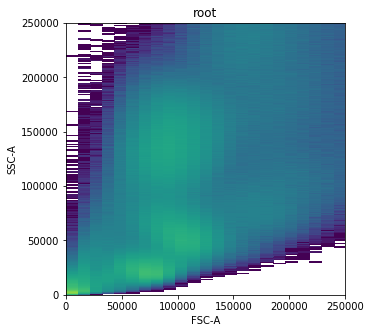

In [63]:
t.plotting.plot_population('root', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

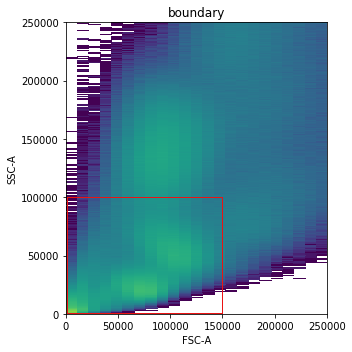

In [64]:
children = ChildPopulationCollection('geom')
children.add_population('cells', definition='+')
children.add_population('debris', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None,
             x_min=1000, y_min=1000, x_max=150000, y_max=100000)
t.create_gate(gate_name='boundary', 
              parent='root',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('boundary')

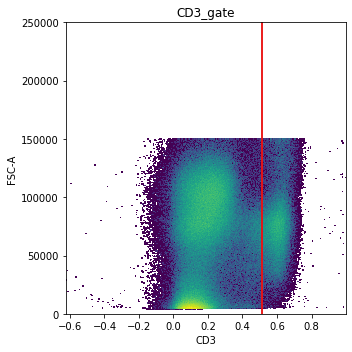

In [65]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD3+', definition='+')
children.add_population('CD3-', definition='-')
kwargs = dict(x='CD3', transform_x='logicle', kde_bw=0.1, low_memory=True, peak_threshold=0.05)
t.create_gate(gate_name='CD3_gate', 
              parent='cells',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('CD3_gate')

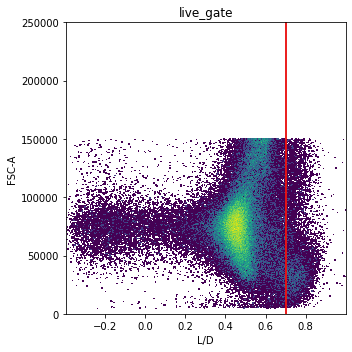

In [66]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('dead', definition='+')
children.add_population('live', definition='-')
kwargs = dict(x='L/D', transform_x='logicle', kde_bw=0.1, low_memory=True,
             ignore_double_pos=True, peak_threshold=0.05)
t.create_gate(gate_name='live_gate', 
              parent='CD3+',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
t.apply('live_gate')

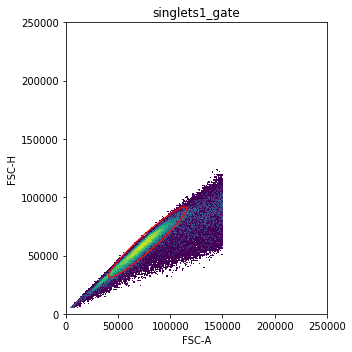

In [67]:
children = ChildPopulationCollection('geom')
children.add_population('singlets1', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
t.create_gate(gate_name='singlets1_gate', 
              parent='live',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
t.apply('singlets1_gate')

In [68]:
children = ChildPopulationCollection('geom')
children.add_population('single_Live_CD3+', definition='+')
children.add_population('doublets2', definition='-')
kwargs = dict(x='FSC-A', y='SSC-W', transform_x=None, transform_y=None, target=(75000, 70000),
             conf=0.99)
t.create_gate(gate_name='singlets2_gate', 
              parent='singlets1',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)

True

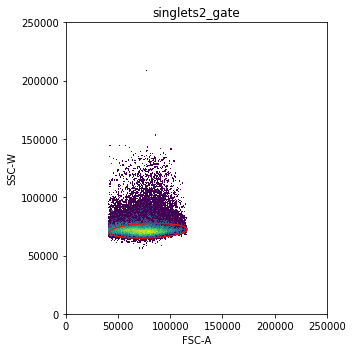

In [69]:
t.apply('singlets2_gate')

In [70]:
t.save(overwrite=True)

Saved successfully!


True

In [71]:
t.save_new_template('Preprocessing PDMC T', overwrite=True)

Overwriting existing gating template Preprocessing PDMC T


True

<h2>Applying the preprocessing template to the remaining samples</h2>

In [31]:
def apply_template(sample_id):
    print(f'------------------ {sample_id} ------------------')
    t = Template(texp, sample_id)
    if 'boundary' in t.gates.keys():
        t.remove_gate('boundary', propagate=True)
    t.load_template('Preprocessing PDMC T')
    t.apply_many(apply_all=True, plot_outcome=True)
    print('Gating complete!')
    print('Saving...')
    t.save(overwrite=True)
    print('Sample gated and saved!')

<h2>Check Gates</h2>

In [20]:
sample_list = [s for s in texp.list_samples() if s != '267-02_pdmc_t']

In [21]:
def plot_all(sample_id):
    print(f'--------------- {sample_id} ---------------')
    gates = ['boundary', 'lymphocyte_gate', 'singlets1', 'singlets2', 'liveCD3_gate']
    t = Gating(texp, sample_id)
    t.plotting.plot_gate('boundary', transforms={'x': None, 'y': None})
    t.plotting.plot_gate('liveCD3_gate', transforms={'x': None, 'y': None})
    t.plotting.plot_gate('singlets1_gate', transforms={'x': None, 'y': None})
    t.plotting.plot_gate('singlets2_gate', transforms={'x': None, 'y': None})

<h3>142-09</h3>

------------------ 142-09_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


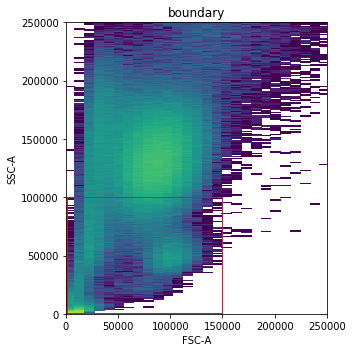

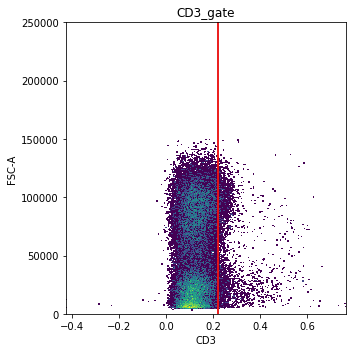

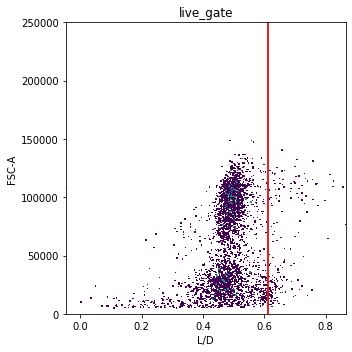

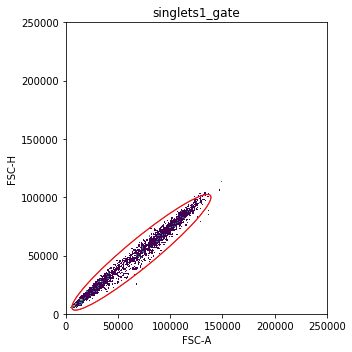

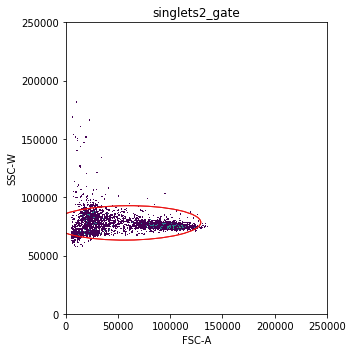

In [73]:
apply_template('142-09_pdmc_t')

**Remove 142-09_pdmc_t from analysis**

In [ ]:
fg = texp.pull_sample(sample_list[0])

In [ ]:
fg.flags = 'invalid'
fg.notes = 'Low cell count;no CD3+ cells'
fg.save()

<h3>165-09</h3>

------------------ 165-09_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


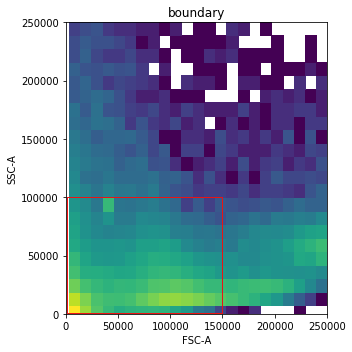

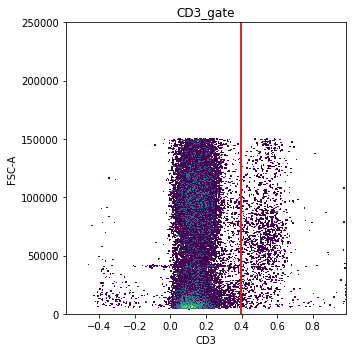

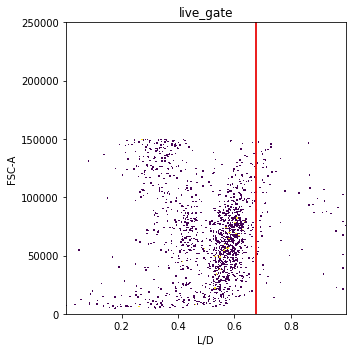

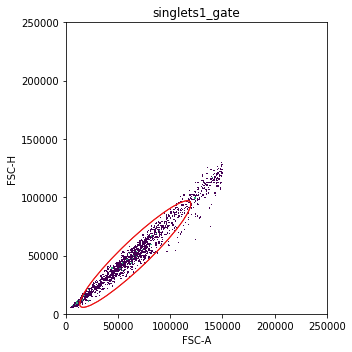

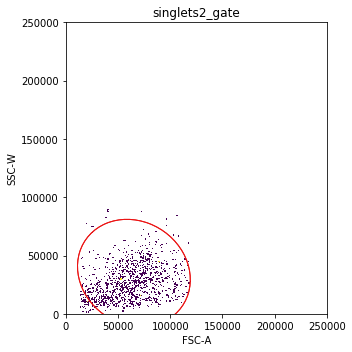

In [74]:
apply_template('165-09_pdmc_t')

<h3>175-09</h3>

------------------ 175-09_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


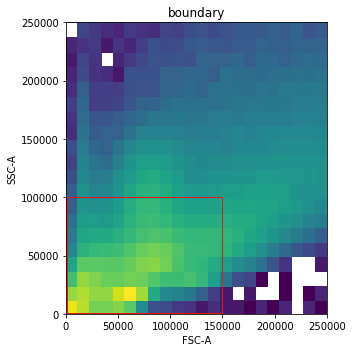

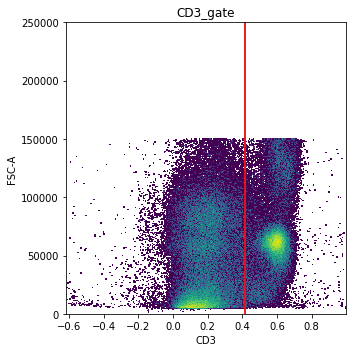

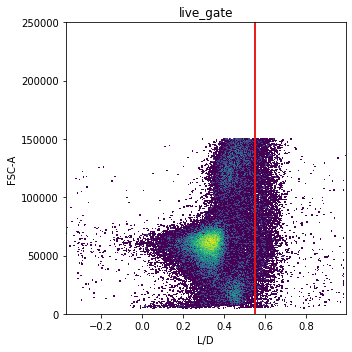

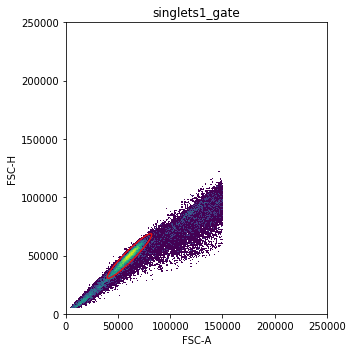

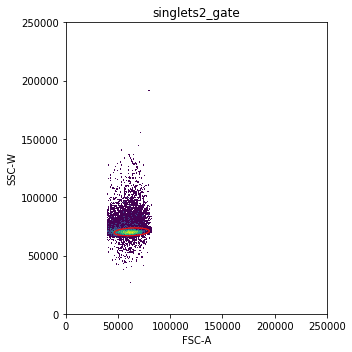

In [75]:
apply_template('175-09_pdmc_t')

<h3>209-03 FAILED</h3>

------------------ 209-03_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


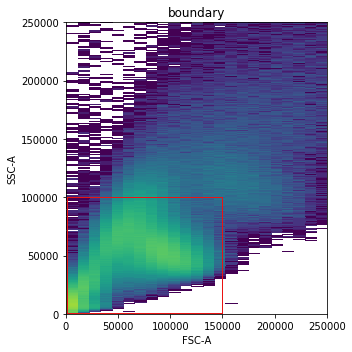

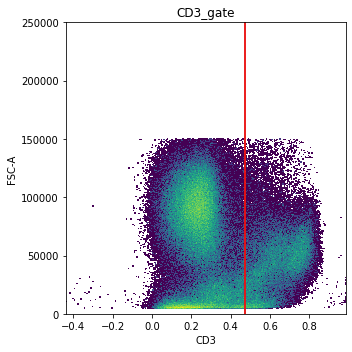

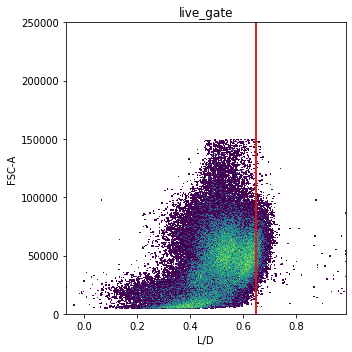

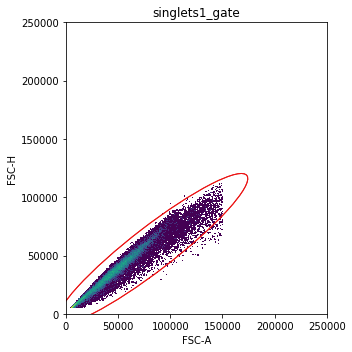

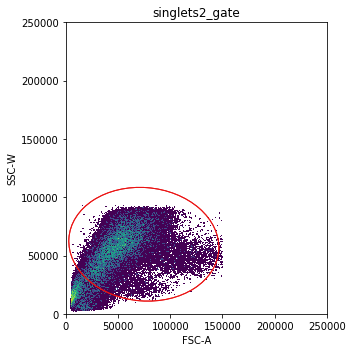

In [52]:
apply_template('209-03_pdmc_t')

<h3>209-05</h3>

------------------ 209-05_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


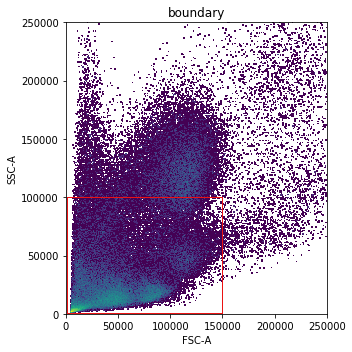

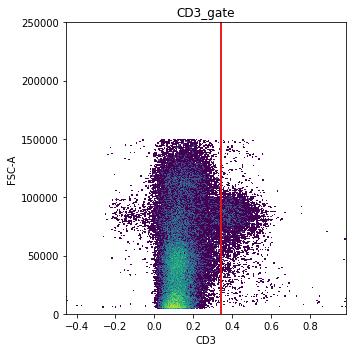

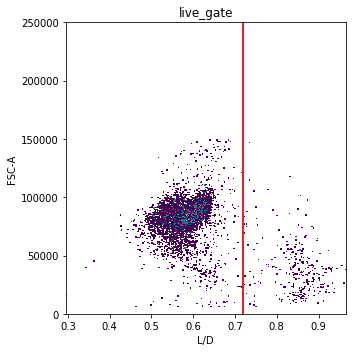

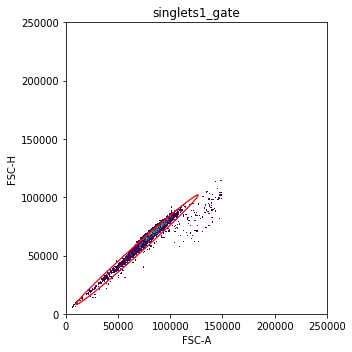

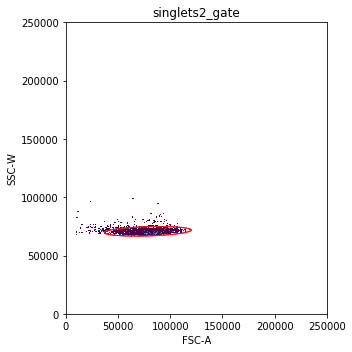

In [4]:
apply_template('209-05_pdmc_t')

<h3>210-14 FAILED</h3>

------------------ 210-14_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


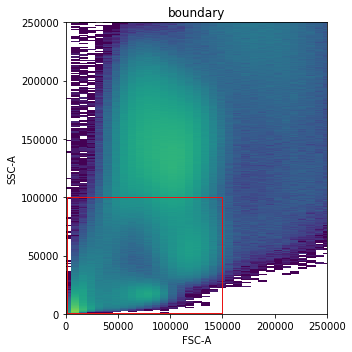

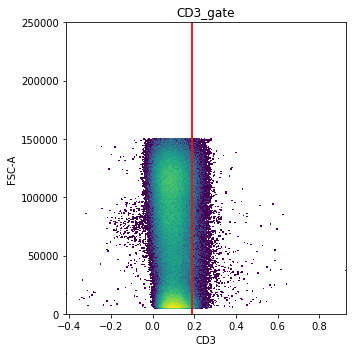

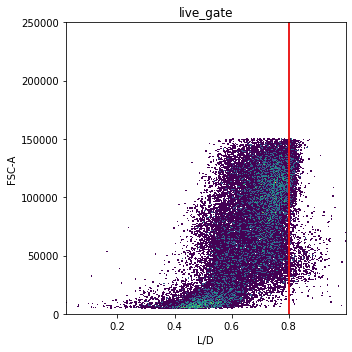

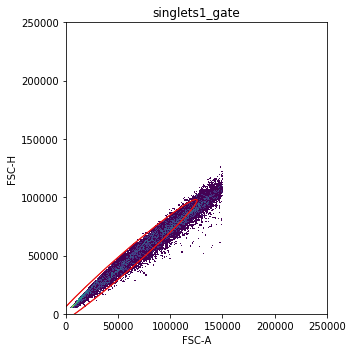

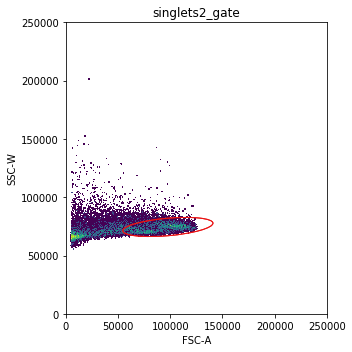

In [51]:
apply_template('210-14_pdmc_t')

Checking the original FACs analysis, CD3 stain failed in the whole panel therefore invalidating this sample for high dimensional analysis.


**Remove 210-14_pdmc_t from analysis**

In [ ]:
fg = texp.pull_sample(sample_list[5])

In [ ]:
fg.flags = 'invalid'
fg.notes = 'CD3 stain failed in whole panel'
fg.save()

<h3>239-02</h3>

------------------ 239-02_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


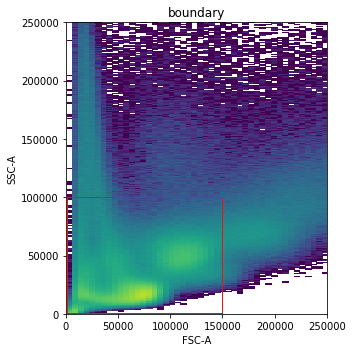

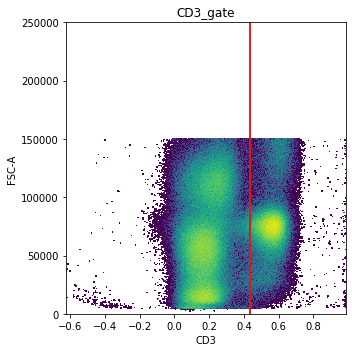

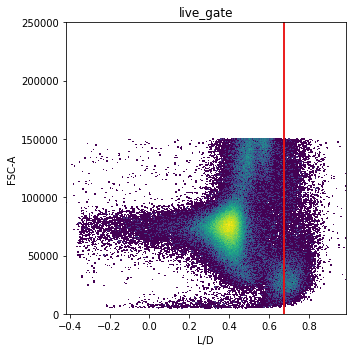

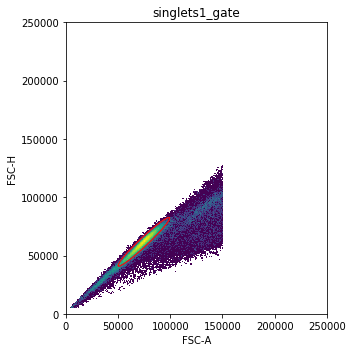

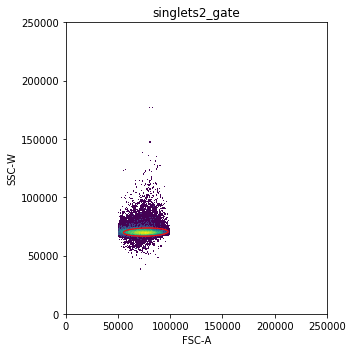

In [6]:
apply_template('239-02_pdmc_t')

<h3>239-04</h3>

In [35]:
t = Gating(texp, '239-04_pdmc_t')
x = list(t.gates.keys())
for _ in x:
    t.gates.pop(_)
x = [p for p in t.populations.keys() if p != 'root']
for _ in x:
    t.populations.pop(_)
t.save(overwrite=True)

Saved successfully!


True

------------------ 239-04_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


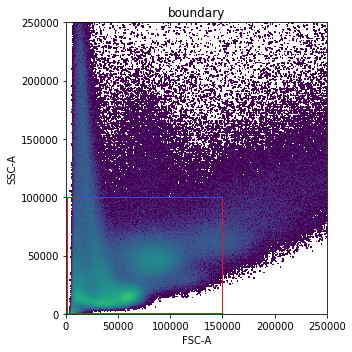

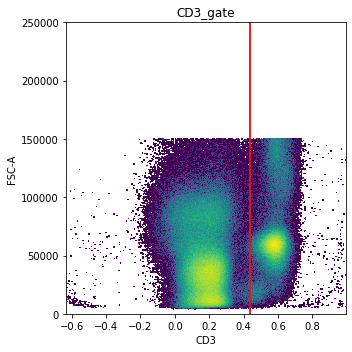

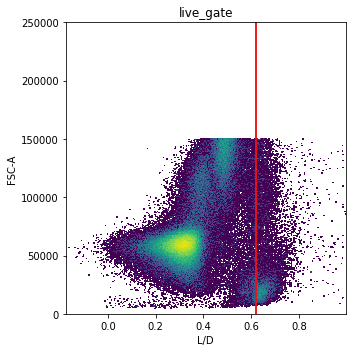

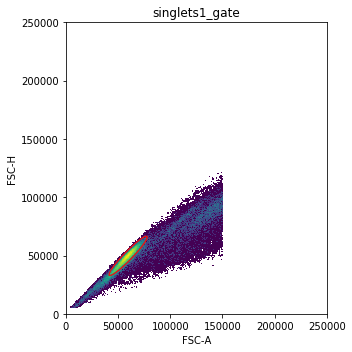

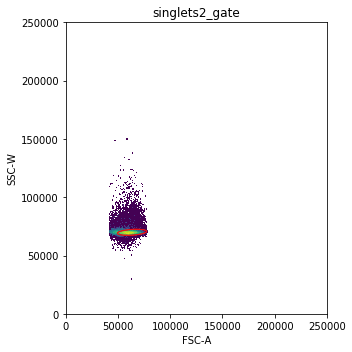

In [36]:
apply_template('239-04_pdmc_t')

<h3>251-07</h3>

------------------ 251-07_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


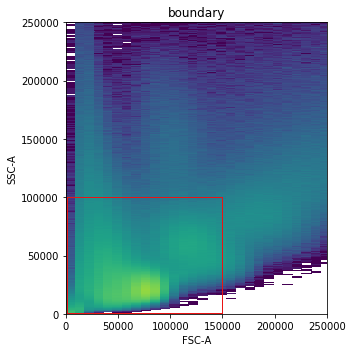

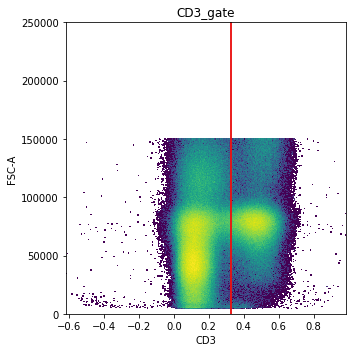

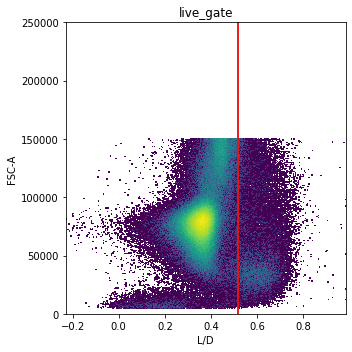

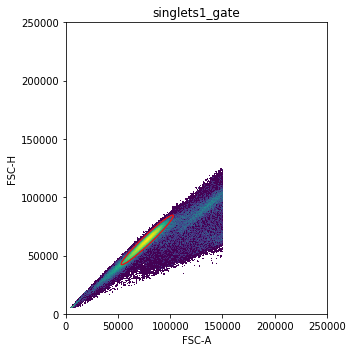

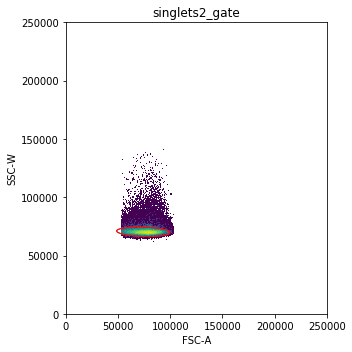

In [50]:
apply_template('251-07_pdmc_t')

<h3>251-08</h3>

------------------ 251-08_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


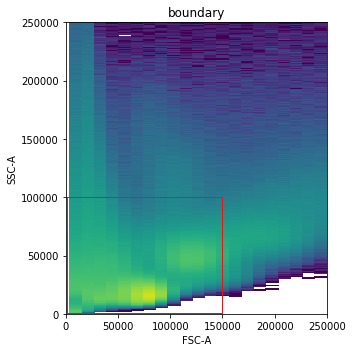

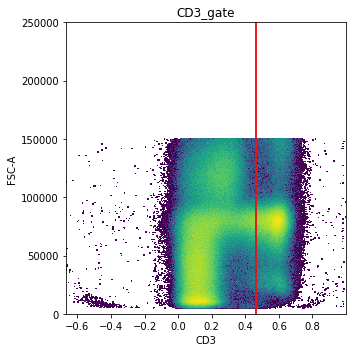

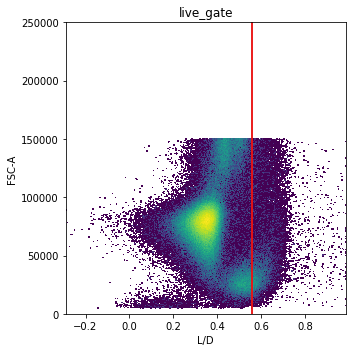

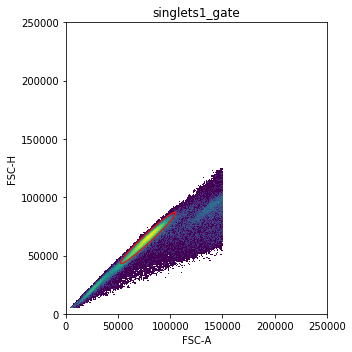

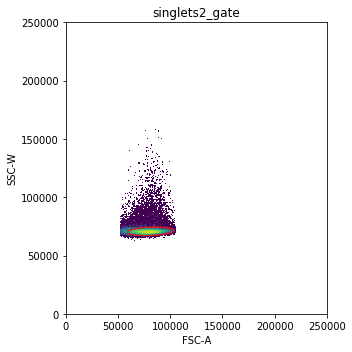

In [38]:
apply_template('251-08_pdmc_t')

<h3>254-04</h3>

------------------ 254-04_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


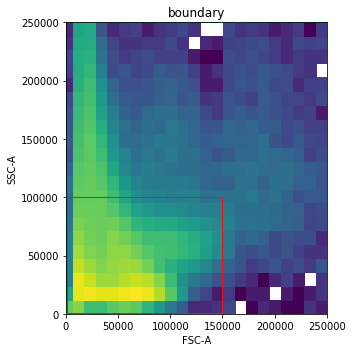

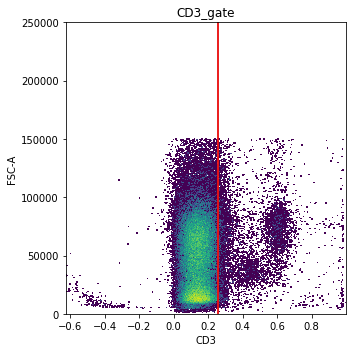

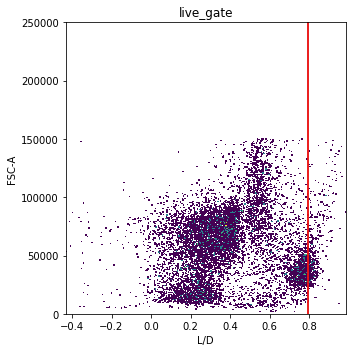

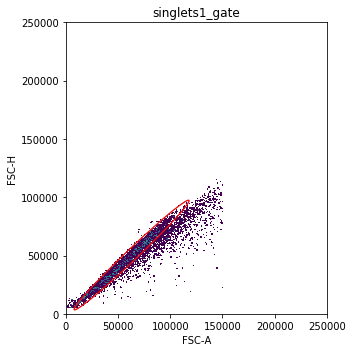

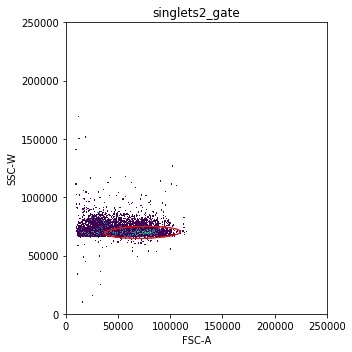

In [39]:
apply_template('254-04_pdmc_t')

<h3>254-05</h3>

In [41]:
t = Gating(texp, '254-05_pdmc_t')
x = list(t.gates.keys())
for _ in x:
    t.gates.pop(_)
x = [p for p in t.populations.keys() if p != 'root']
for _ in x:
    t.populations.pop(_)
t.save(overwrite=True)

Saved successfully!


True

------------------ 254-05_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


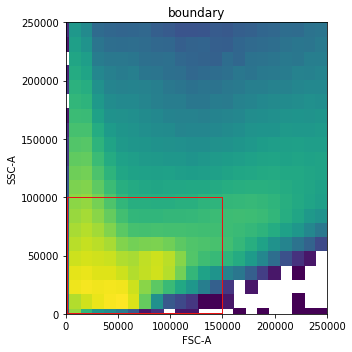

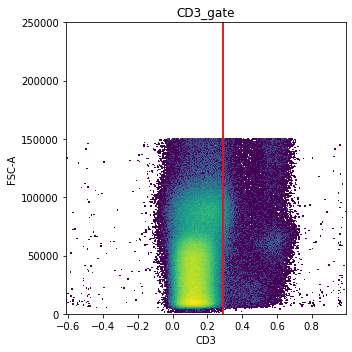

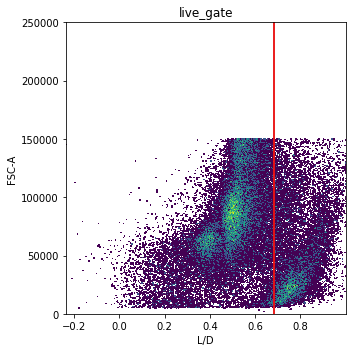

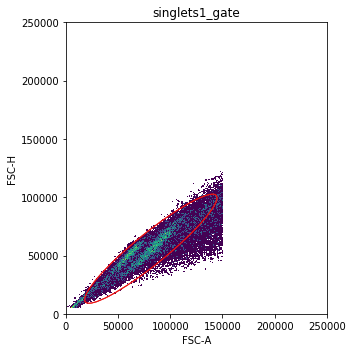

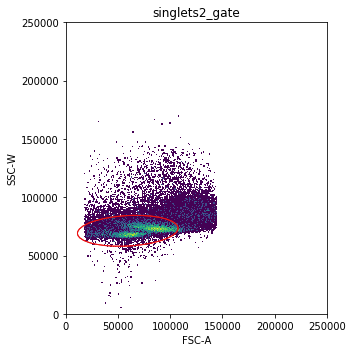

In [49]:
apply_template('254-05_pdmc_t')

<h3>255-04</h3>

------------------ 255-04_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


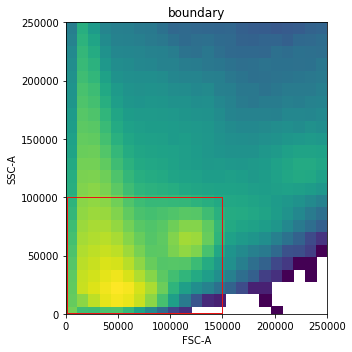

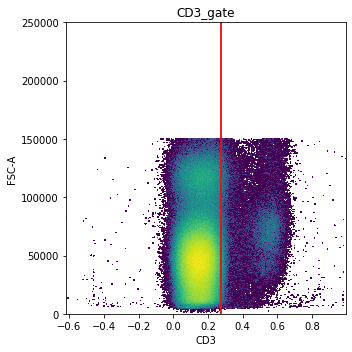

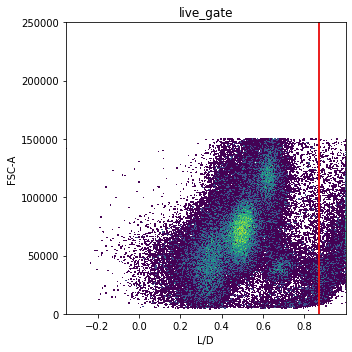

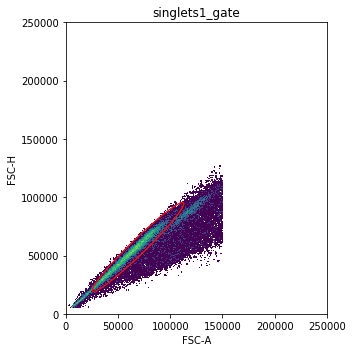

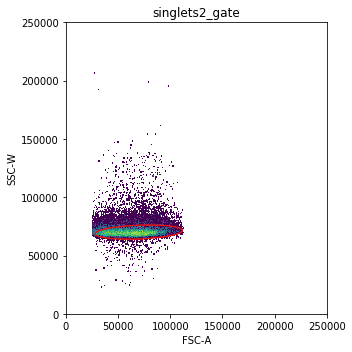

In [43]:
apply_template('255-04_pdmc_t')

<h3>255-05</h3>

------------------ 255-05_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


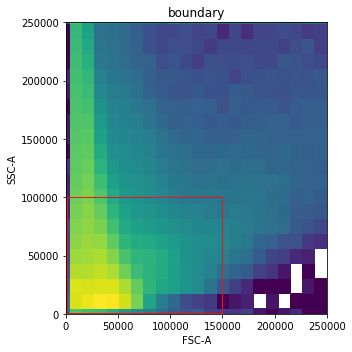

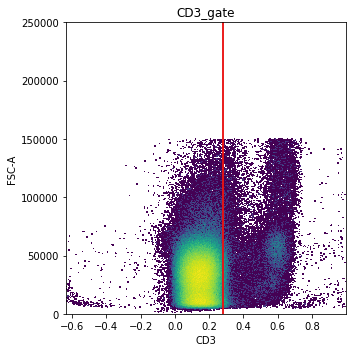

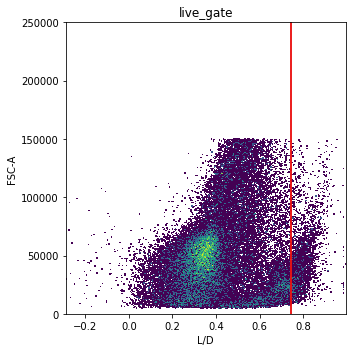

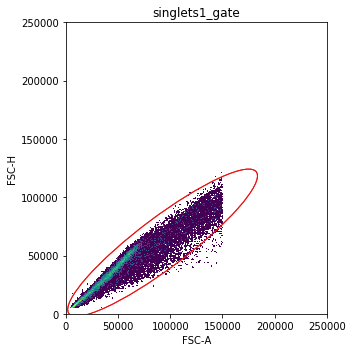

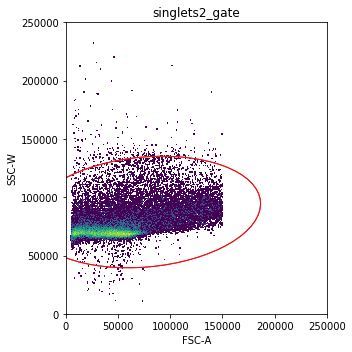

In [44]:
apply_template('255-05_pdmc_t')

<h3>264-02</h3>

------------------ 264-02_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


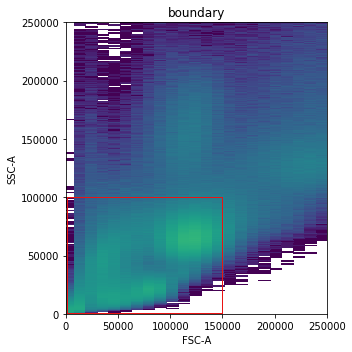

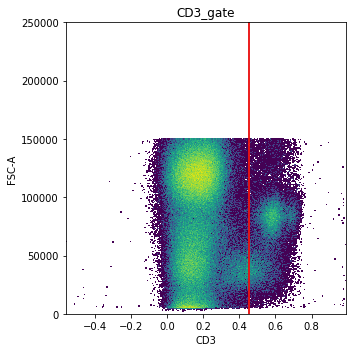

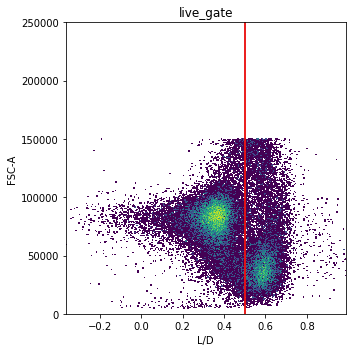

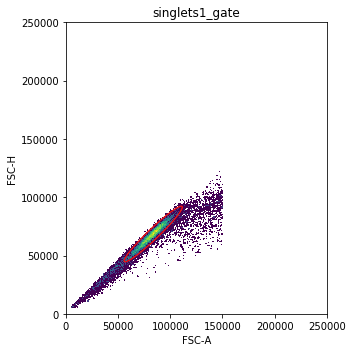

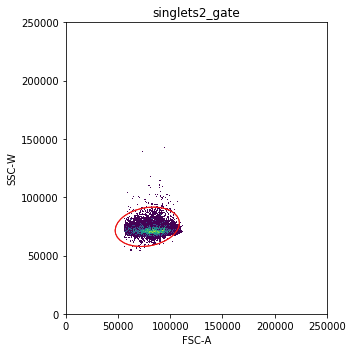

In [48]:
apply_template('264-02_pdmc_t')

<h3>273-01 FAILED</h3>

------------------ 273-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


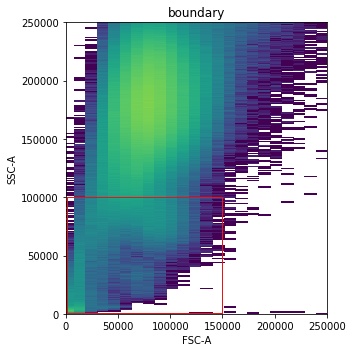

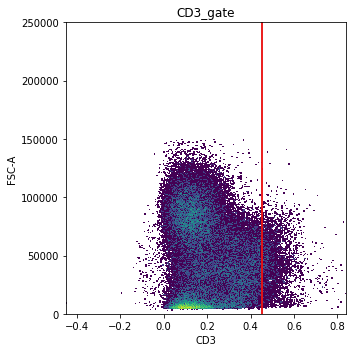

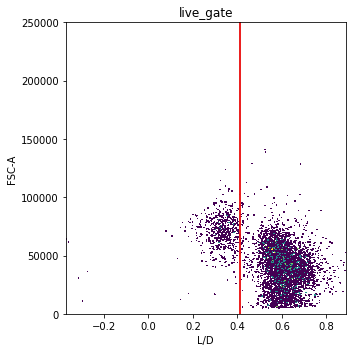

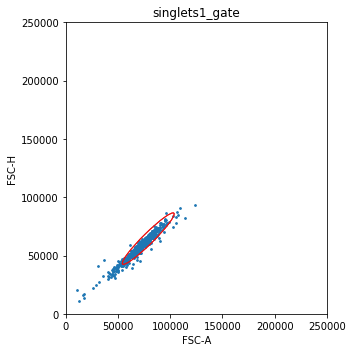

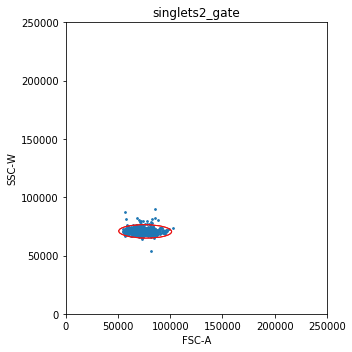

In [47]:
apply_template('273-01_pdmc_t')

<h3>276-01</h3>

------------------ 276-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


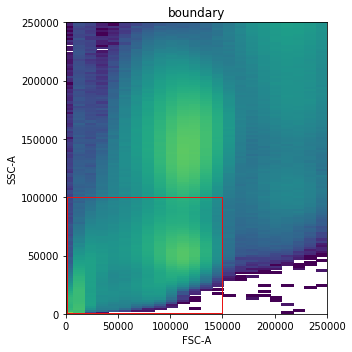

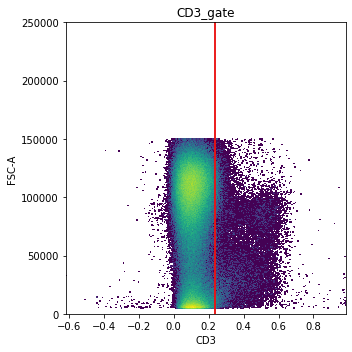

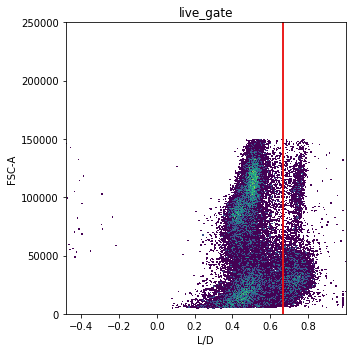

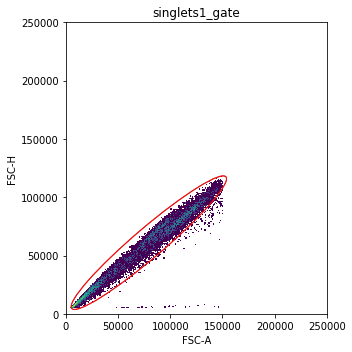

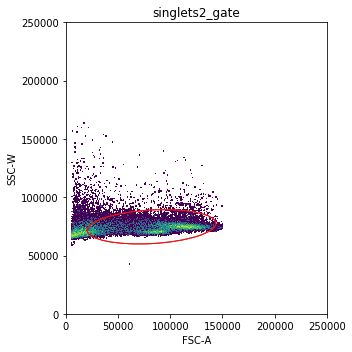

In [53]:
apply_template('276-01_pdmc_t')

<h3>286-03</h3>

------------------ 286-03_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


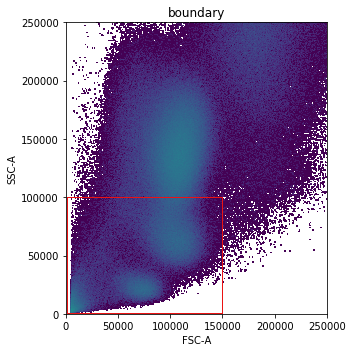

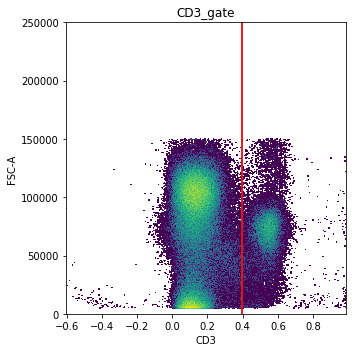

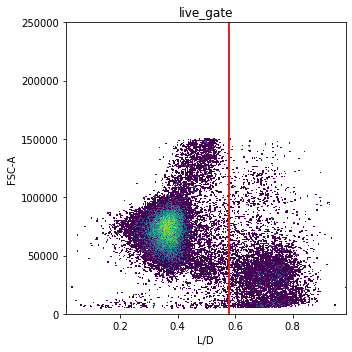

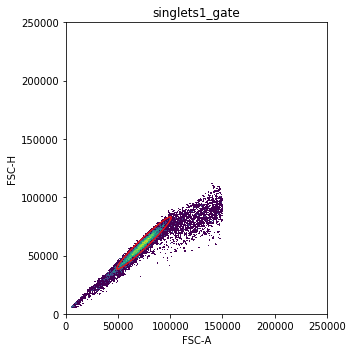

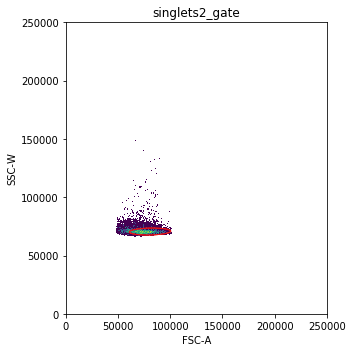

In [54]:
apply_template('286-03_pdmc_t')

<h3>286-04</h3>

------------------ 286-04_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


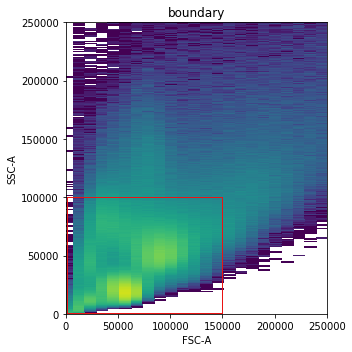

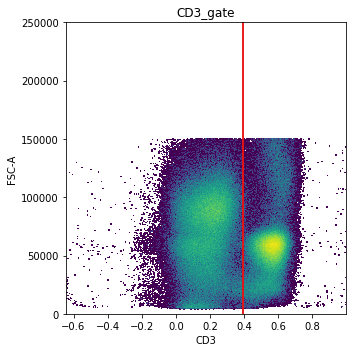

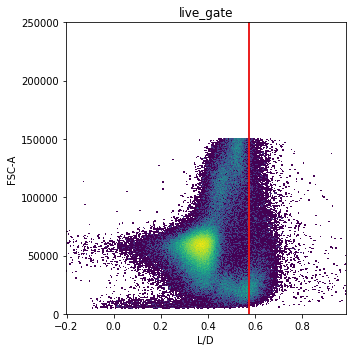

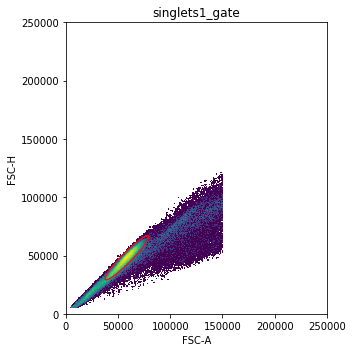

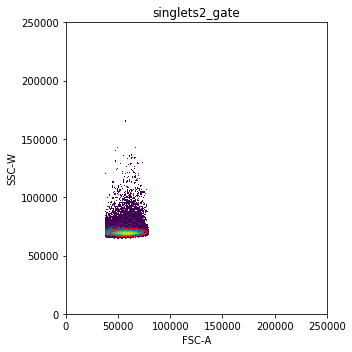

In [55]:
apply_template('286-04_pdmc_t')

<h3>294-02</h3>

------------------ 294-02_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


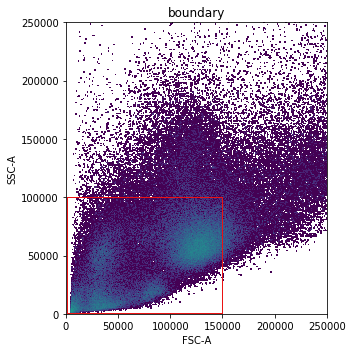

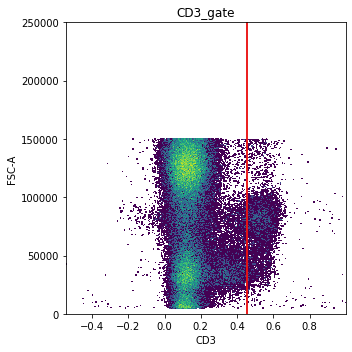

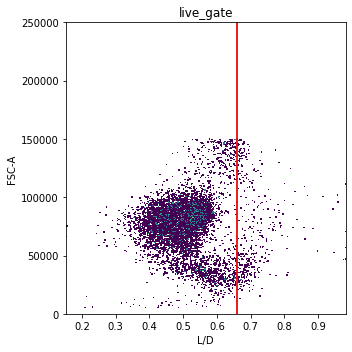

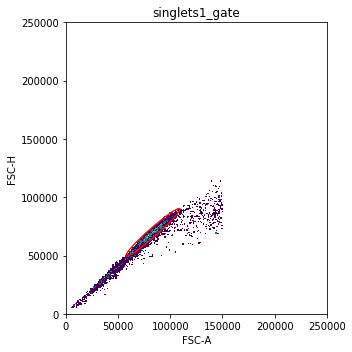

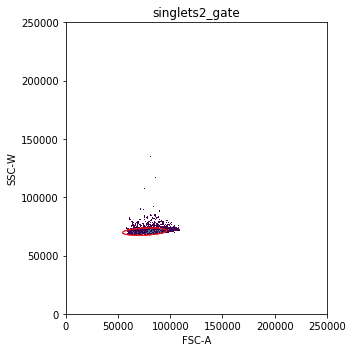

In [56]:
apply_template('294-02_pdmc_t')

<h3>294-03</h3>

------------------ 294-03_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


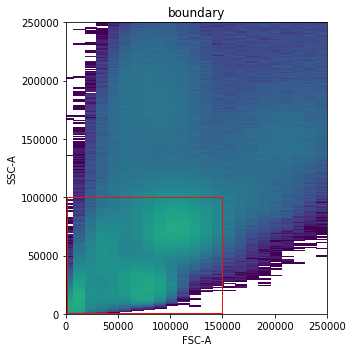

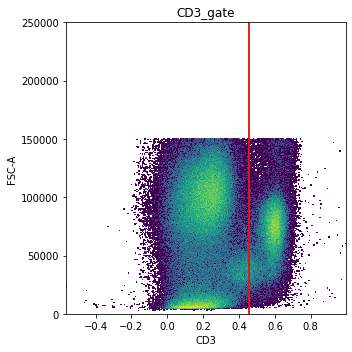

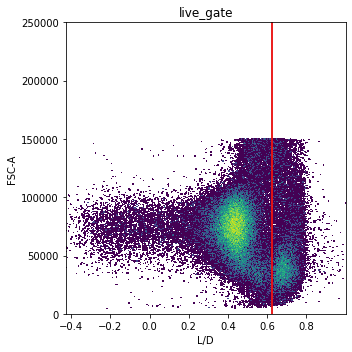

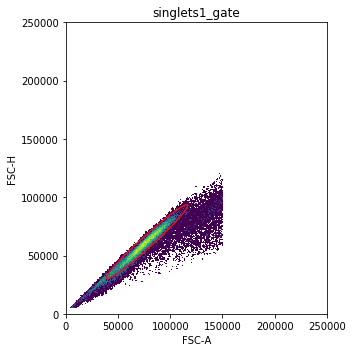

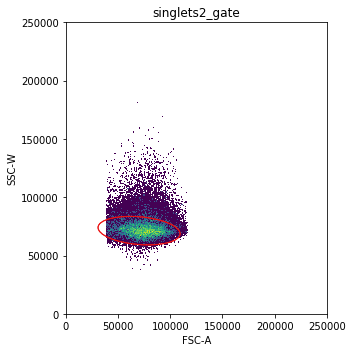

In [57]:
apply_template('294-03_pdmc_t')

<h3>298-01 FAILED</h3>

------------------ 298-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


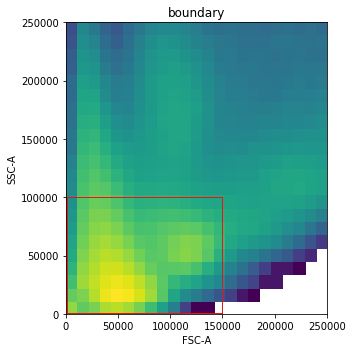

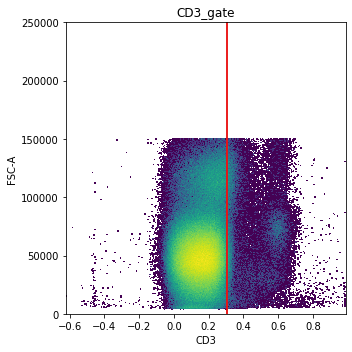

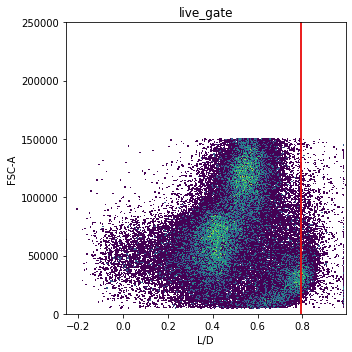

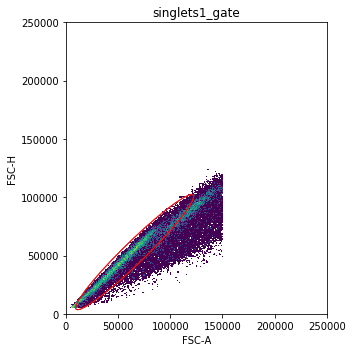

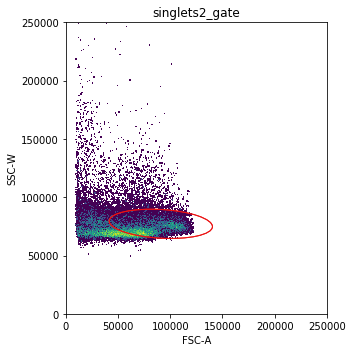

In [58]:
apply_template('298-01_pdmc_t')

<h3>305-01</h3>

------------------ 305-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


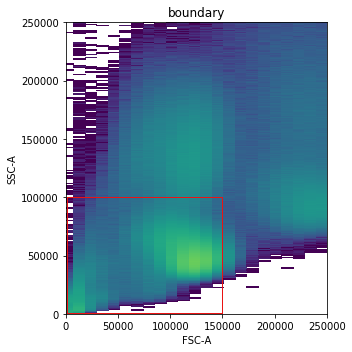

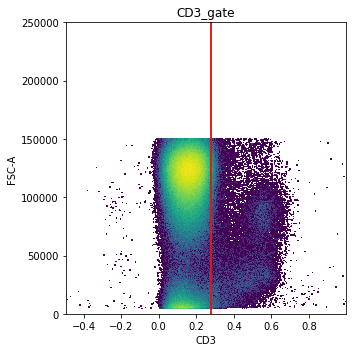

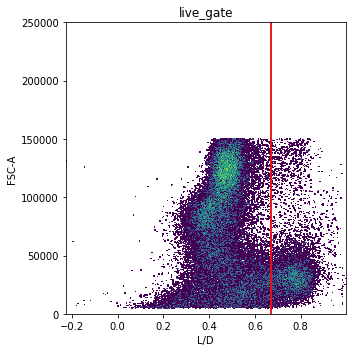

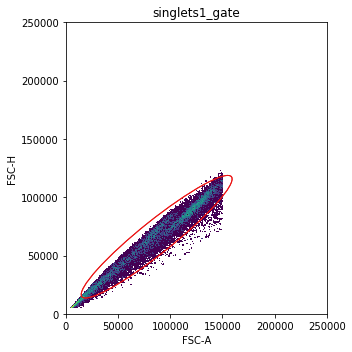

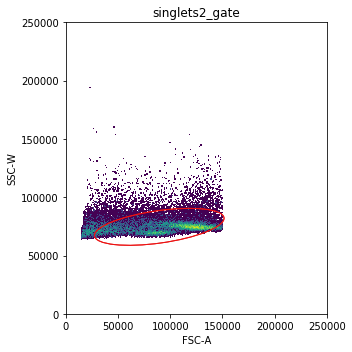

In [59]:
apply_template('305-01_pdmc_t')

<h3>305-03</h3>

------------------ 305-03_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


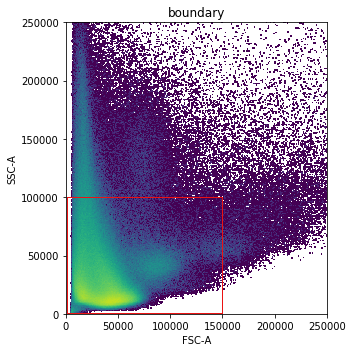

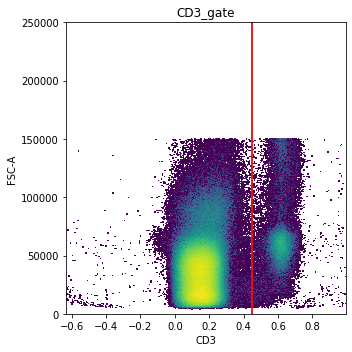

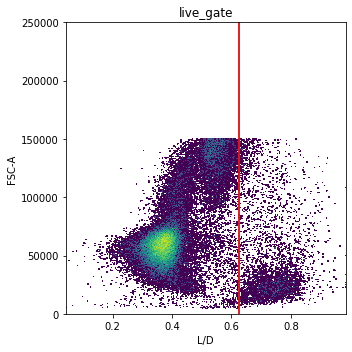

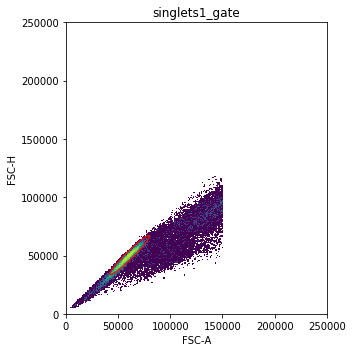

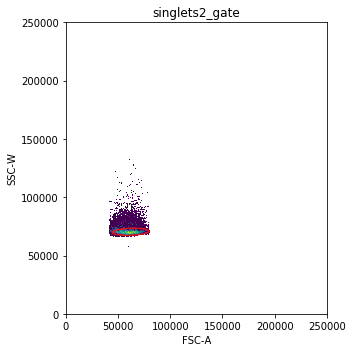

In [60]:
apply_template('305-03_pdmc_t')

<h3>306-01</h3>

------------------ 306-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


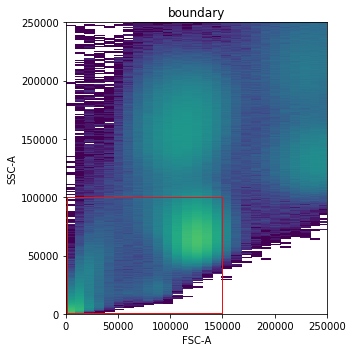

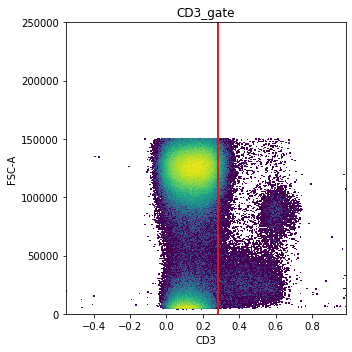

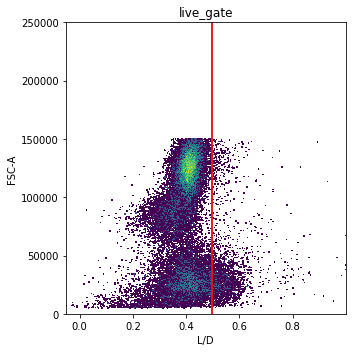

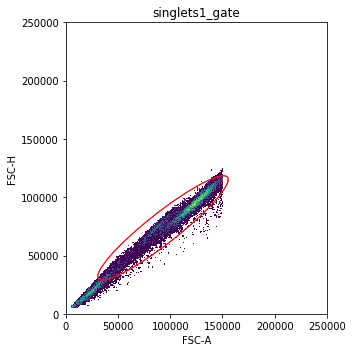

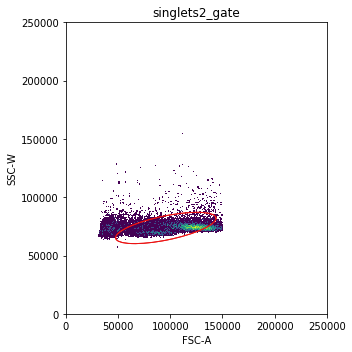

In [61]:
apply_template('306-01_pdmc_t')

<h3>308-02R</h3>

------------------ 308-02R_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


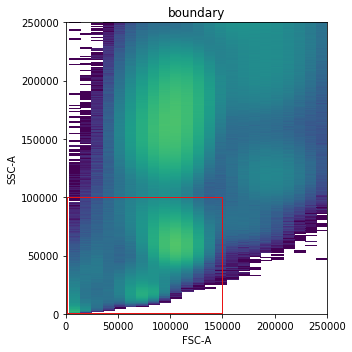

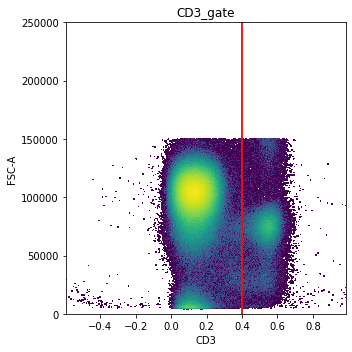

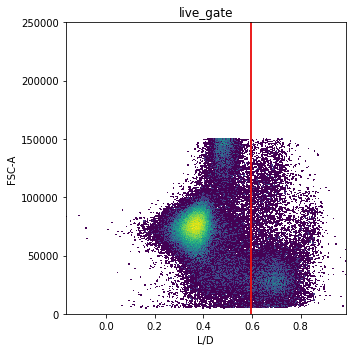

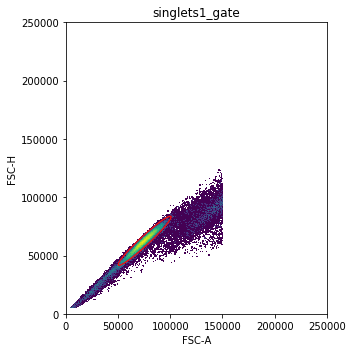

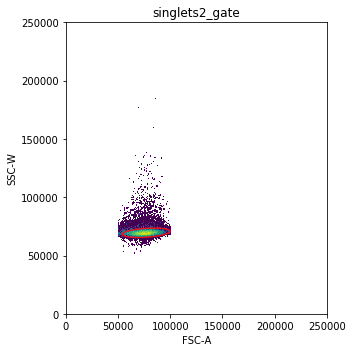

In [62]:
apply_template('308-02R_pdmc_t')

<h3>308-03R</h3>

------------------ 308-03R_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


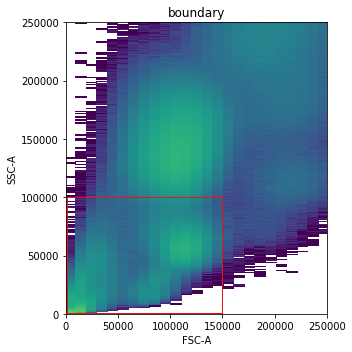

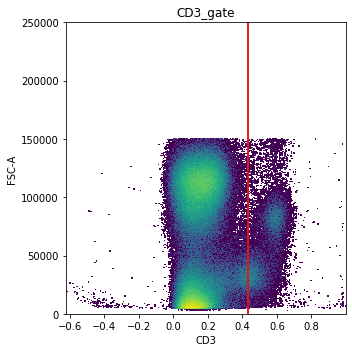

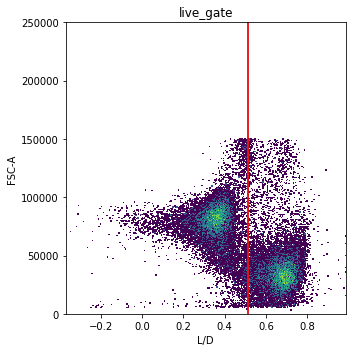

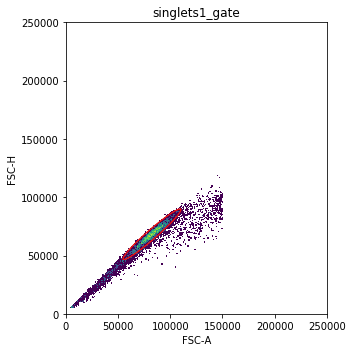

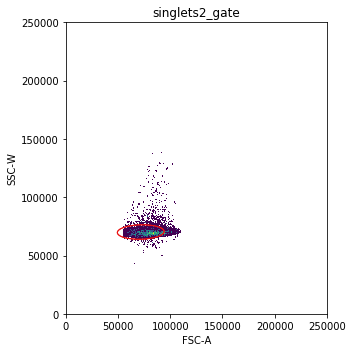

In [63]:
apply_template('308-03R_pdmc_t')

<h3>308-04</h3>

------------------ 308-04_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


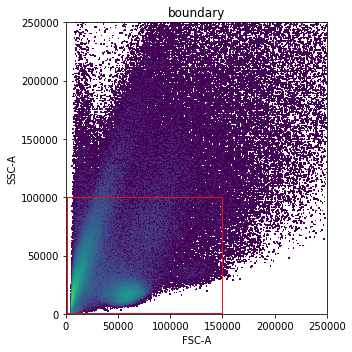

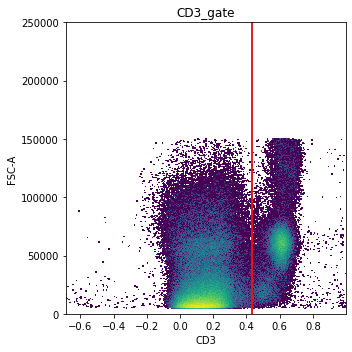

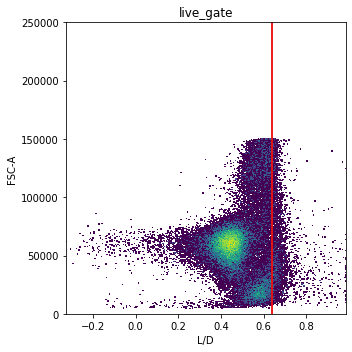

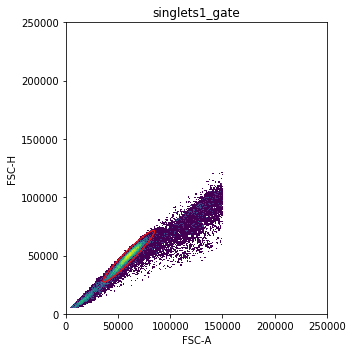

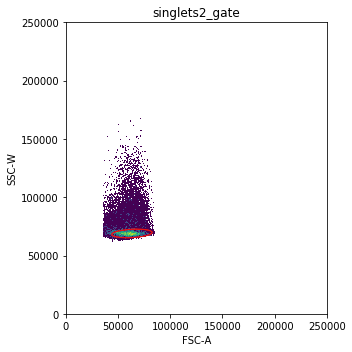

In [64]:
apply_template('308-04_pdmc_t')

<h3>310-01</h3>

------------------ 310-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


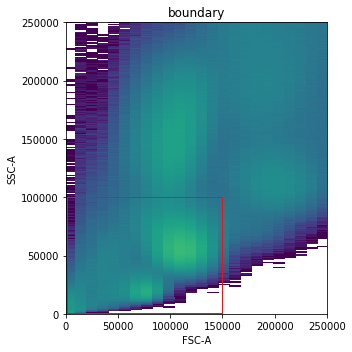

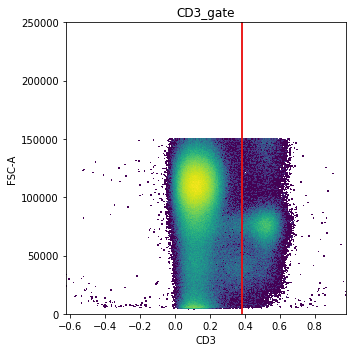

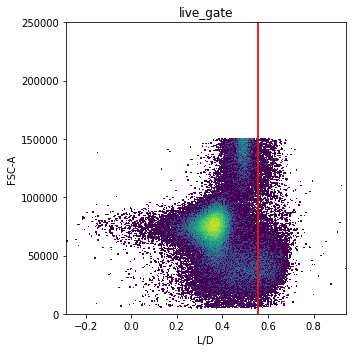

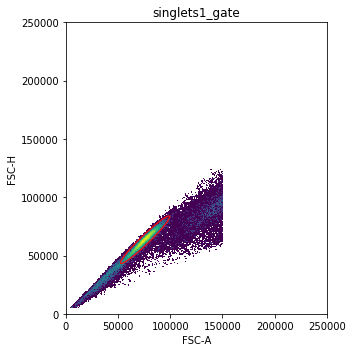

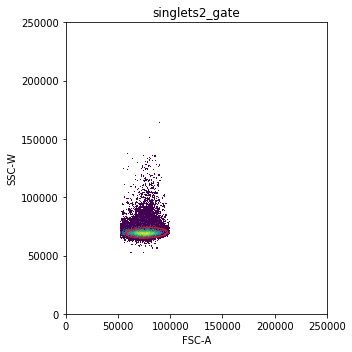

In [65]:
apply_template('310-01_pdmc_t')

<h3>315-01</h3>

------------------ 315-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


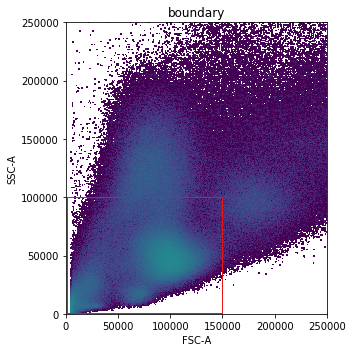

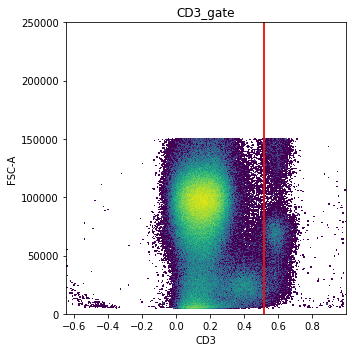

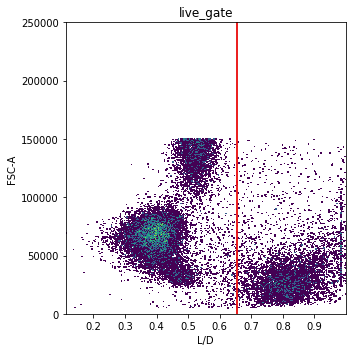

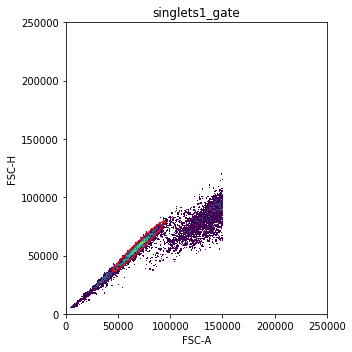

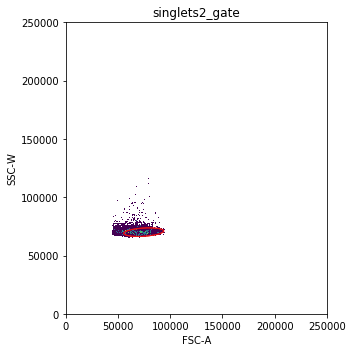

In [66]:
apply_template('315-01_pdmc_t')

<h3>315-02</h3>

------------------ 315-02_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


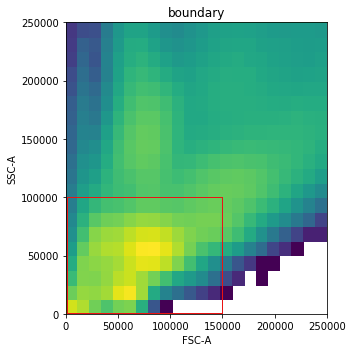

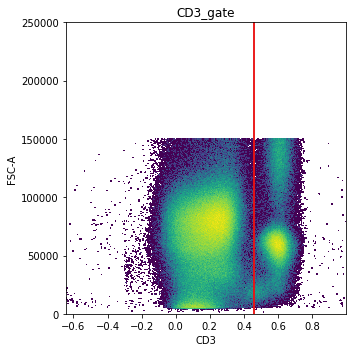

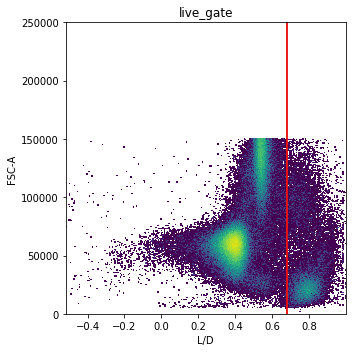

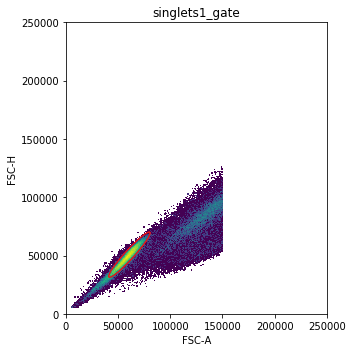

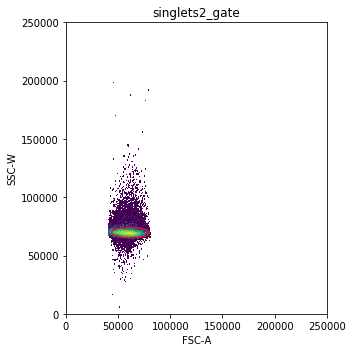

In [67]:
apply_template('315-02_pdmc_t')

<h3>318-01</h3>

------------------ 318-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


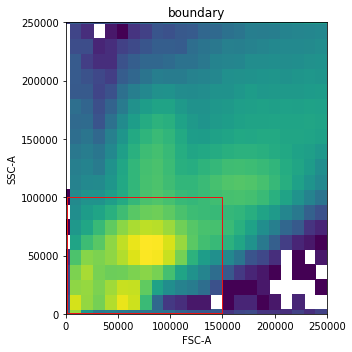

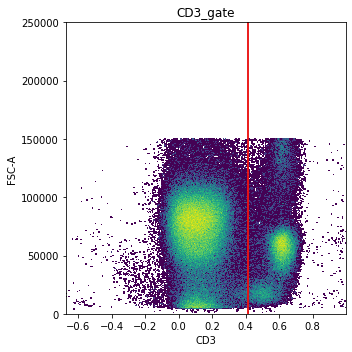

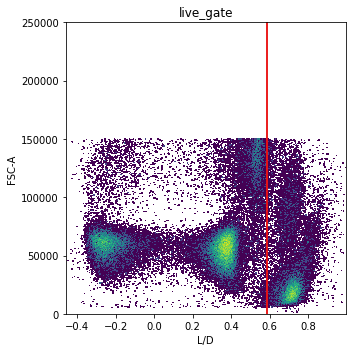

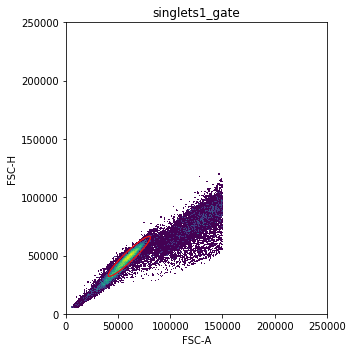

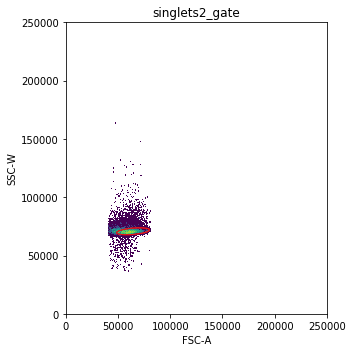

In [68]:
apply_template('318-01_pdmc_t')

<h3>322-01 FAILED</h3>

------------------ 322-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


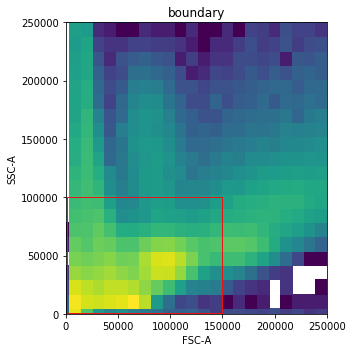

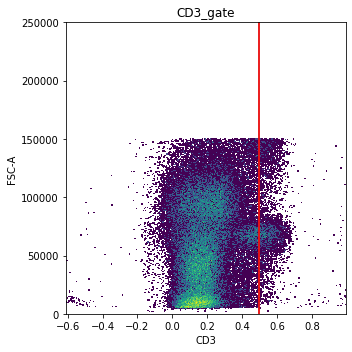

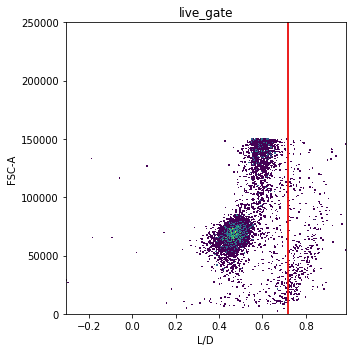

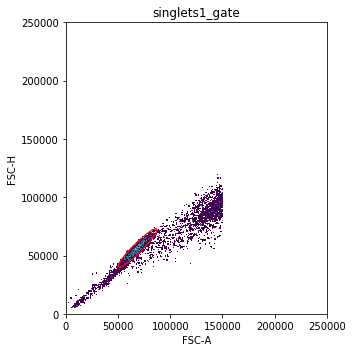

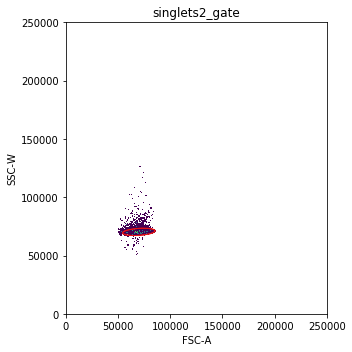

In [69]:
apply_template('322-01_pdmc_t')

<h3>323-01</h3>

------------------ 323-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


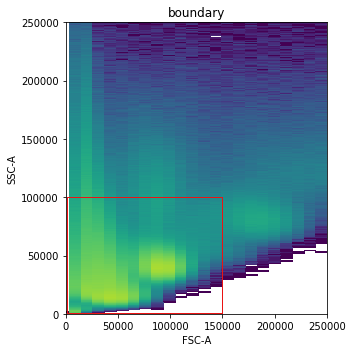

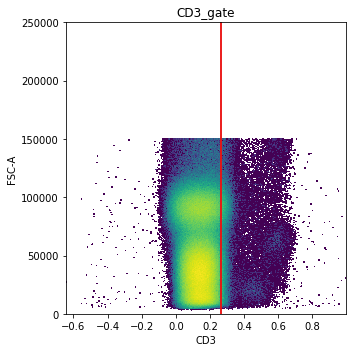

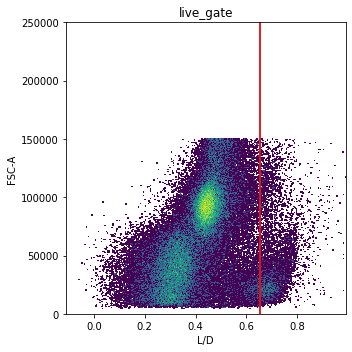

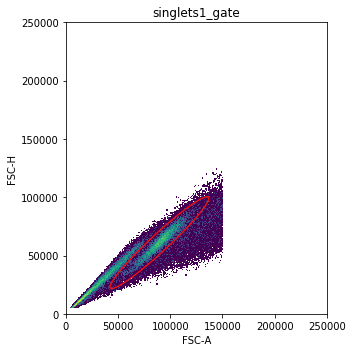

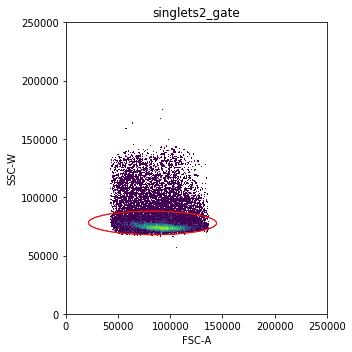

In [70]:
apply_template('323-01_pdmc_t')

<h3>324-01</h3>

------------------ 324-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


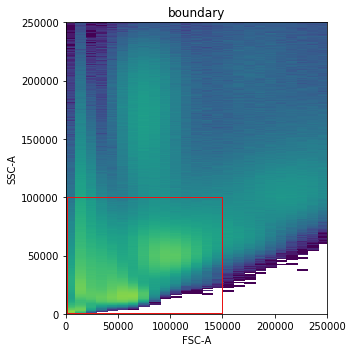

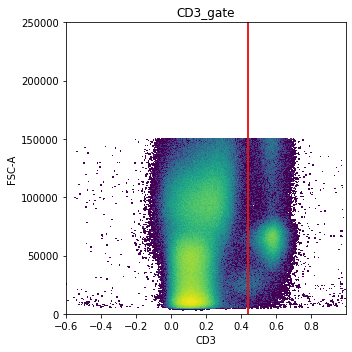

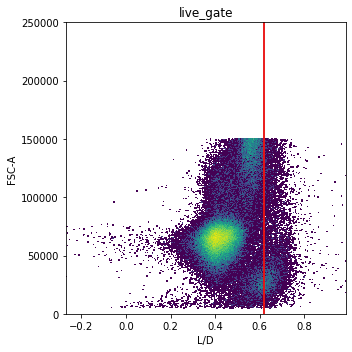

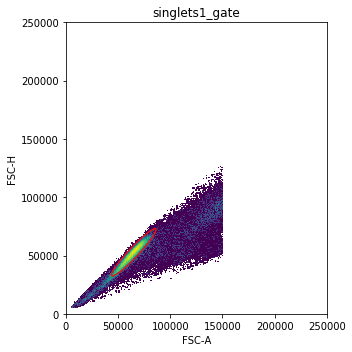

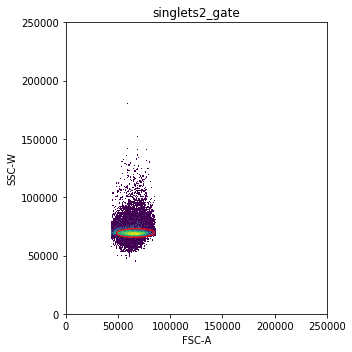

In [71]:
apply_template('324-01_pdmc_t')

<h3>326-01</h3>

------------------ 326-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


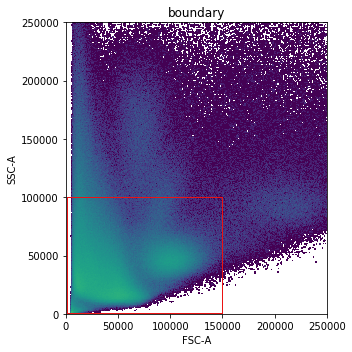

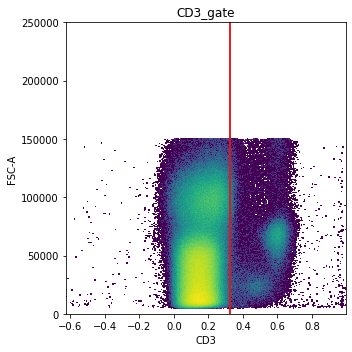

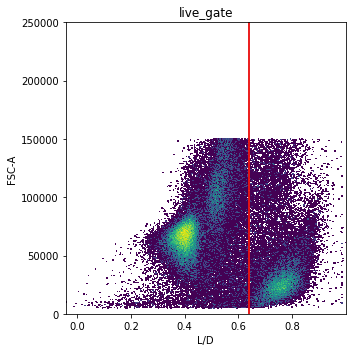

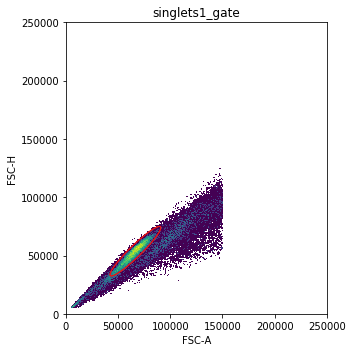

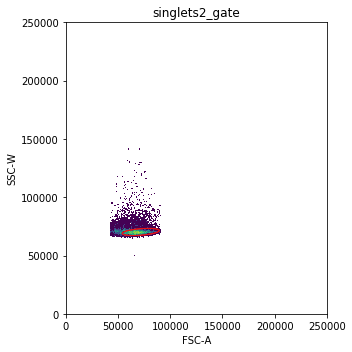

In [72]:
apply_template('326-01_pdmc_t')

<h3>237-06 FAILED</h3>

------------------ 237-06_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


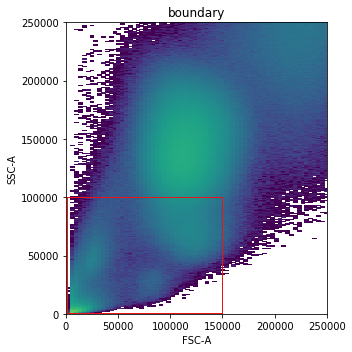

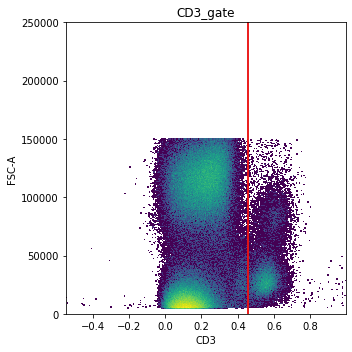

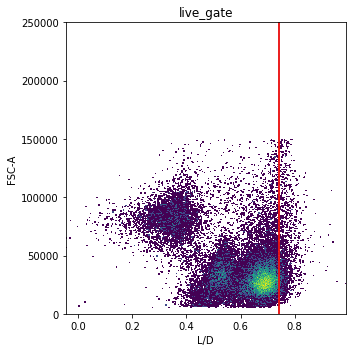

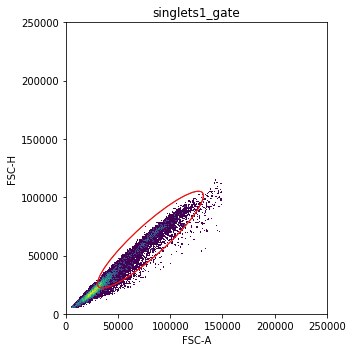

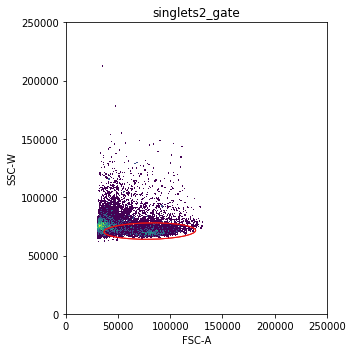

In [73]:
apply_template('237-06_pdmc_t')

<h3>267-01</h3>

------------------ 267-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


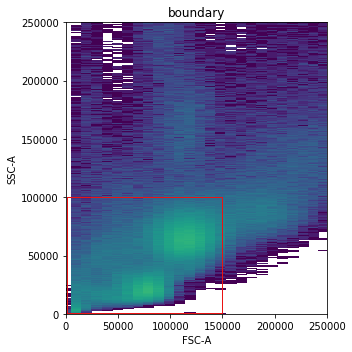

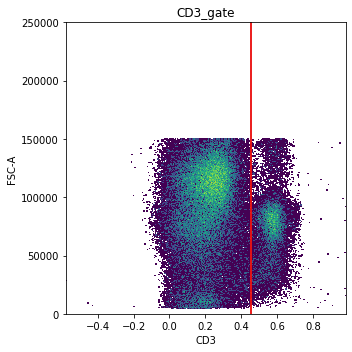

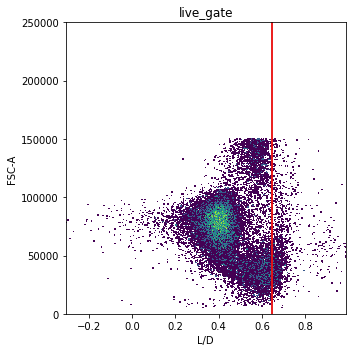

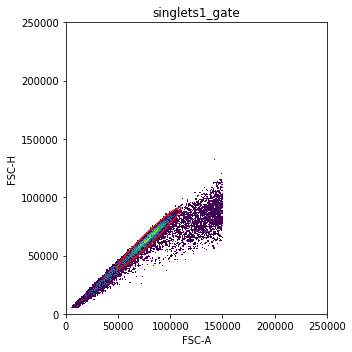

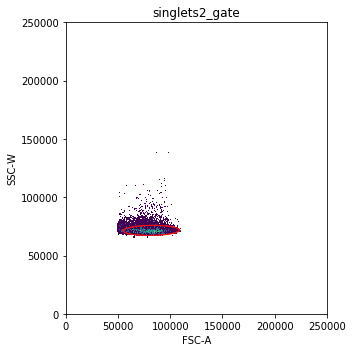

In [74]:
apply_template('267-01_pdmc_t')

<h3>279-03</h3>

------------------ 279-03_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


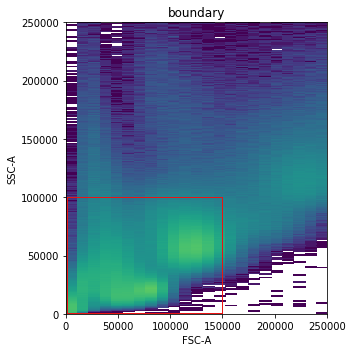

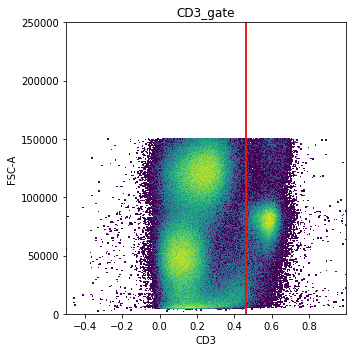

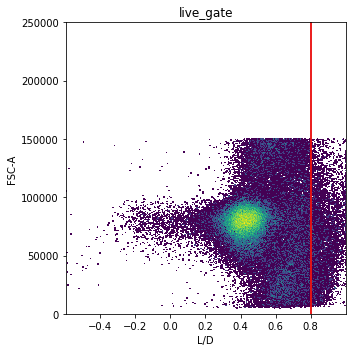

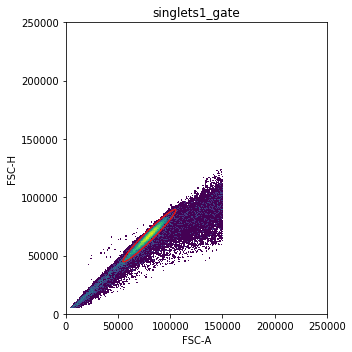

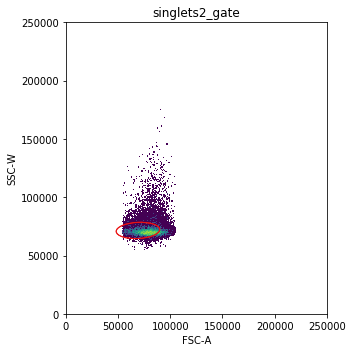

In [75]:
apply_template('279-03_pdmc_t')

<h3>286-02</h3>

------------------ 286-02_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


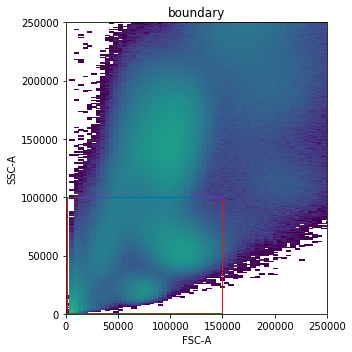

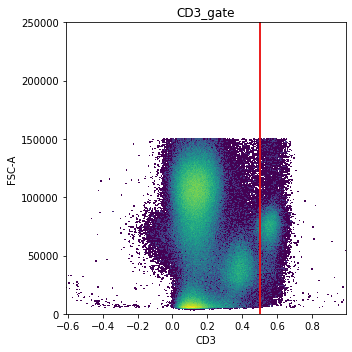

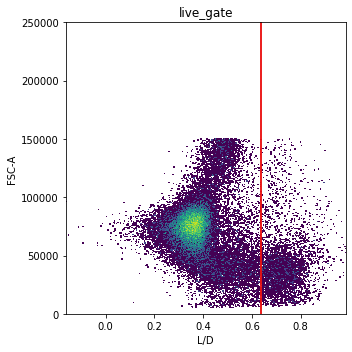

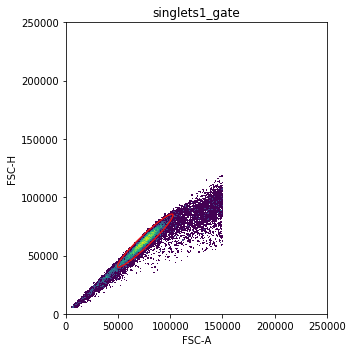

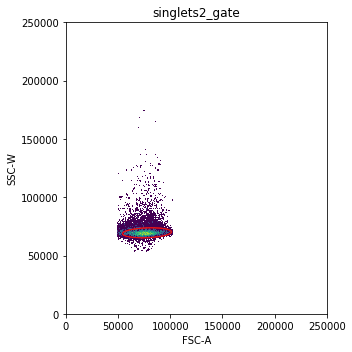

In [76]:
apply_template('286-02_pdmc_t')

<h3>288-02</h3>

------------------ 288-02_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


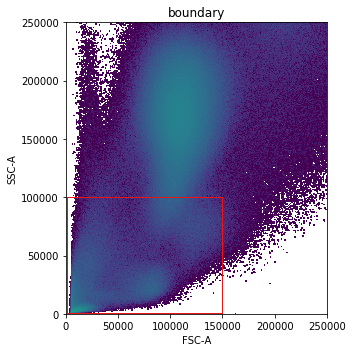

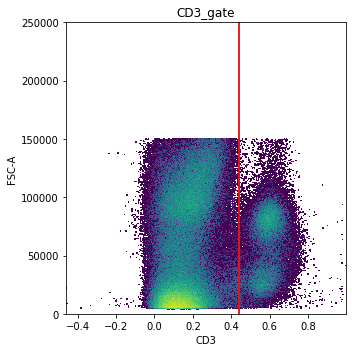

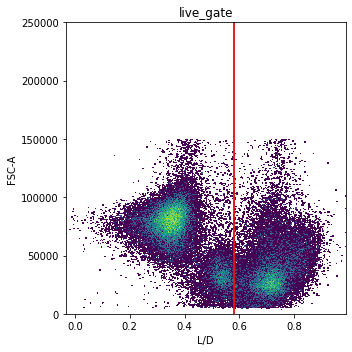

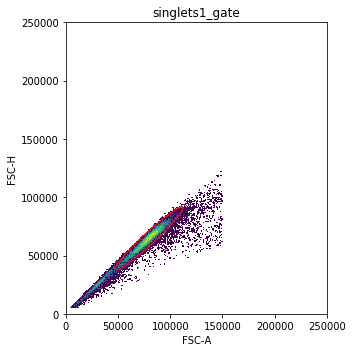

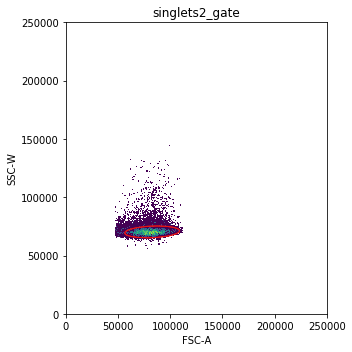

In [77]:
apply_template('288-02_pdmc_t')

<h3>294-01</h3>

------------------ 294-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


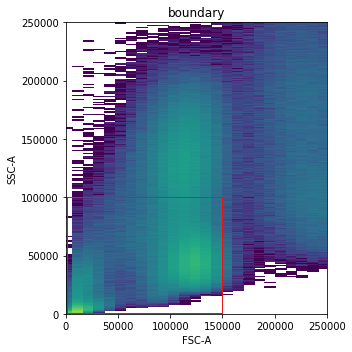

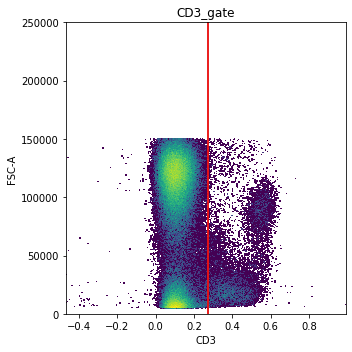

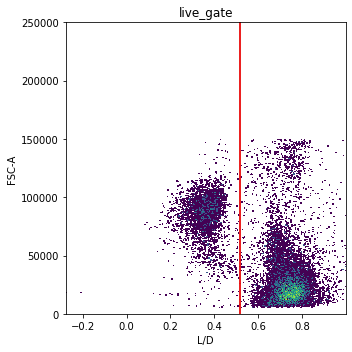

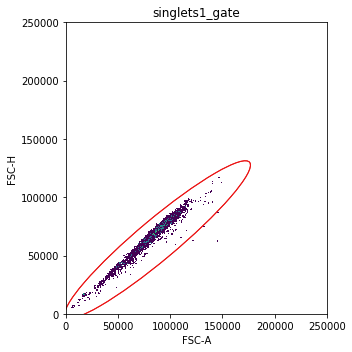

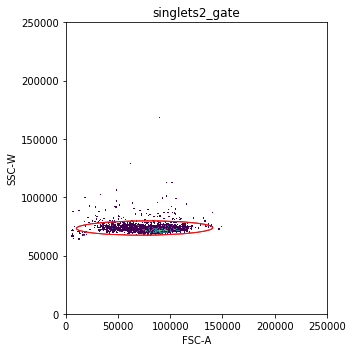

In [78]:
apply_template('294-01_pdmc_t')

<h3>302-01 FAILED</h3>

------------------ 302-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


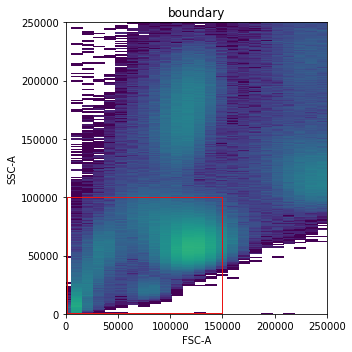

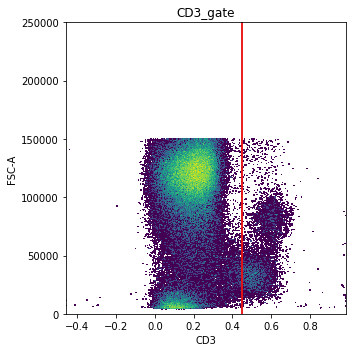

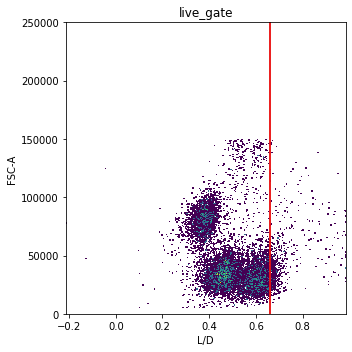

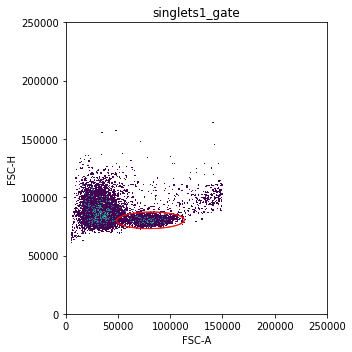

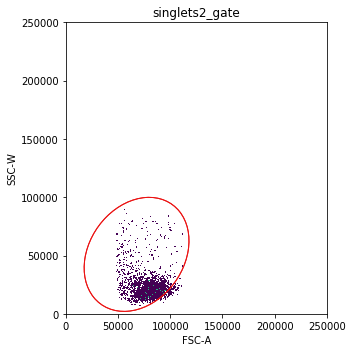

In [79]:
apply_template('302-01_pdmc_t')

<h3>315-01</h3>

------------------ 315-01_pdmc_t ------------------
Applying boundary...
Applying CD3_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!
Gating complete!
Saving...
Saved successfully!
Sample gated and saved!


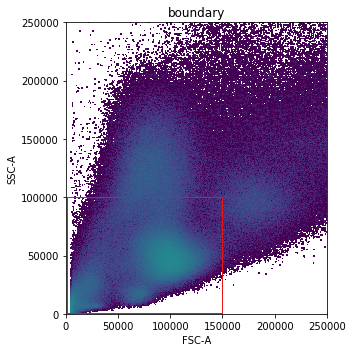

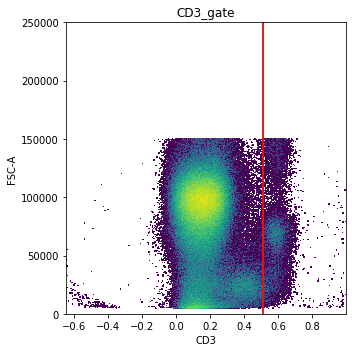

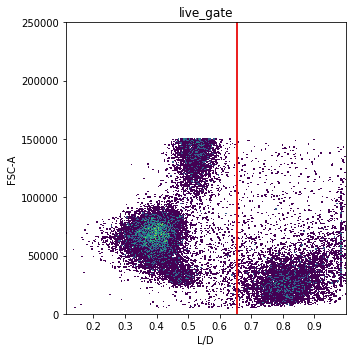

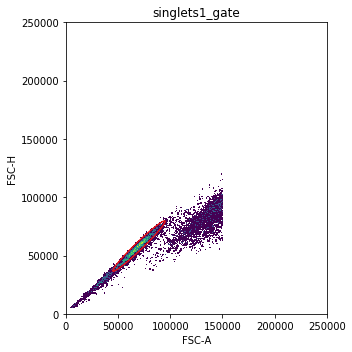

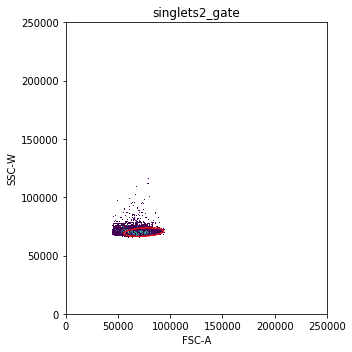

In [80]:
apply_template('315-01_pdmc_t')

In [81]:
invalid = ['209-03', '210-14', '273-01', '298-01', '322-01', '237-06', '302-01']

In [82]:
valid = [x for x in texp.list_samples() if x not in invalid]

In [83]:
len(valid)

45